In [17]:
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

output_directory = '/home/marco/DataspellProjects/thesis/output/xgb/ST001937/'

palette = sns.color_palette(["#2176AB", "#F97662", "#FFBF00", "#50C878", "#B284BE"])
#create a gradient color palette 
gradient_palette = sns.blend_palette(['#ECF7FE', palette[0]], as_cmap=True)
sns.set(style="whitegrid", font_scale=1.5)
sns.set_palette(palette)

# Load the data
df = pd.read_csv('../../../data/ST001937_bm.csv')


In [18]:

# Split the data into features (X) and target variable (y)
X = df.drop('Phenotypes', axis=1)
y = df['Phenotypes']

In [19]:

from sklearn.metrics import roc_curve

best_params = {'gamma': 0.3013694124613676, 'learning_rate': 0.050846072164779786, 'max_depth': 22, 'n_estimators': 550, 'seed': 0, 'subsample': 0.8175882727291021}
# Perform k-fold cross-validation and visualize results
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
score = {'accuracy': [], 'roc_auc': [], 'fpr': [], 'tpr': []}


for train_index, test_index in skf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    xg_clf = xgb.XGBClassifier(**best_params)
    xg_clf.fit(X_train, y_train)

    y_pred = xg_clf.predict(X_test)
    y_prob = xg_clf.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_prob, drop_intermediate=False)

    score['accuracy'].append(accuracy_score(y_test, y_pred))
    score['roc_auc'].append(roc_auc_score(y_test, y_prob))
    score['fpr'].append(fpr.tolist())
    score['tpr'].append(tpr.tolist())

In [20]:
scores_df = pd.read_csv('../../../output/scores.csv')

scores_df = scores_df.append({
    'Model': 'XGB',
    'Dataset': 'ST001937',
    'auc': score['roc_auc'],
    'accuracy': score['accuracy'],
    'fpr': score['fpr'],
    'tpr': score['tpr']
}, ignore_index=True)
scores_df.to_csv('../../../output/scores.csv', index=False)

/tmp/ipykernel_1320428/2366324225.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scores_df = scores_df.append({


Accuracy: 0.83
AUC: 0.89


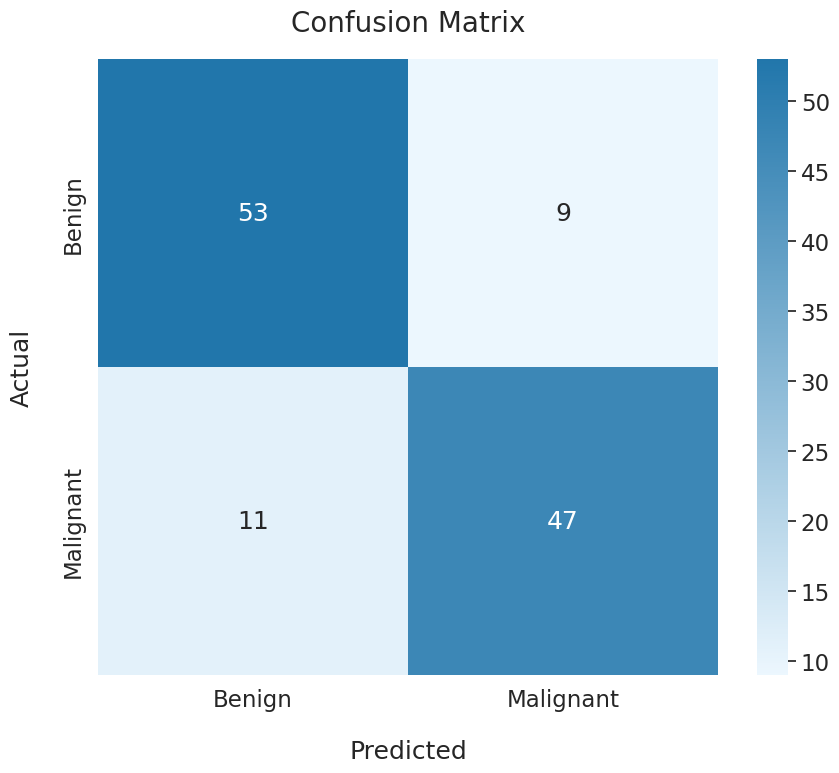

In [16]:
# Plot the confusion matrix

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

xg_clf = xgb.XGBClassifier(**best_params)
xg_clf.fit(X_train, y_train)

y_pred = xg_clf.predict(X_test)
y_prob = xg_clf.predict_proba(X_test)[:, 1]
conf_matrix = confusion_matrix(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)

print(f'Accuracy: {accuracy:.2f}')
print(f'AUC: {auc:.2f}')


plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap=gradient_palette, xticklabels=['Benign', 'Malignant'], yticklabels=['Benign', 'Malignant'])
plt.xlabel('Predicted', labelpad=20)
plt.ylabel('Actual', labelpad=20)
plt.title('Confusion Matrix', pad=20, fontsize=20)
plt.savefig(output_directory + 'XGB_confusion_matrix.png', dpi=300, bbox_inches='tight')